# Tanzanian Water Wells

Author: William Brandon Omballa


## Business Understanding:
The goal of this project is to predict the operating condition of water pumps in Tanzania. The dataset, provided by Taarifa and the Tanzanian Ministry of Water, contains various features describing each water point, including information about the location, construction, management, and more. The target variable is the operating condition of the water pump, which can be classified into three categories: functional, functional needs repair, and non-functional.

## Problem Description:

Clean and potable water is crucial for communities, and predicting the status of water pumps helps in efficient maintenance operations. By understanding which pumps are likely to fail, authorities can optimize resource allocation, reduce downtime, and ensure a consistent water supply. The predictive model will assist in prioritizing maintenance efforts and contribute to the sustainable management of water resources in Tanzania.

## Exploratory Data Analysis (EDA):
### Data Loading and Overview:
The initial step involves loading the data and gaining an overview of its structure.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

'''
Loading the datasets. Since our target variable and features are in different datasets
I am loading both datasets then merging them together.
'''

df1 = pd.read_csv('./data/target.csv')
df2 = pd.read_csv('./data/train.csv')

test_data = pd.read_csv('./data/test.csv')

#Merge the datasets
train_data = pd.merge(df1, df2, on='id')

Create a class to handle the data loading. This will be usefull when we use a pipeline to create much cleaner code.

### Data Summary:
A function data_summary is created to provide a quick summary of the dataset.

In [5]:
# Create a function to show data attributes
def data_summary(dataframe):
    print("----------------Dataset Info-----------------")
    print(dataframe.info())
    print("----------------Dataset Shape-----------------")
    print(dataframe.shape)
    return


In [6]:
# Calling the function
data_summary(train_data)

----------------Dataset Info-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55763 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59398 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_c

### Target Variable Transformation:
The scope of this project is to build a binary classification model. In this case our data is in ternary form and should be changed. This is possible.

Our target variable has three different classes. 1. Functional 2. Non Functional and 3. Functional needs repair.

There are two ways to approach this, either the Functional needs repair be moved to Functional or Non Functional.

I this case I opted for making it to non functional. Although this would group them as not working. It enables the model to predict models that are close to breaking down as Non Functional and this might theoretically enable the organization to fix them before they break.

Also, this approach leads to a higher accuracy for our model



In [7]:
# Change the target variable to binary
train_data['status_group'] = train_data['status_group'].replace({'functional': 1, 'non functional': 0, 'functional needs repair': 0})

### Data Visualization:
Exploratory data analysis involves visualizing data to gain insights. Various plots are generated to understand relationships and patterns in the data.

Geographic Distribution:
Scatter plot to visualize the geographic distribution of functional and non-functional wells.



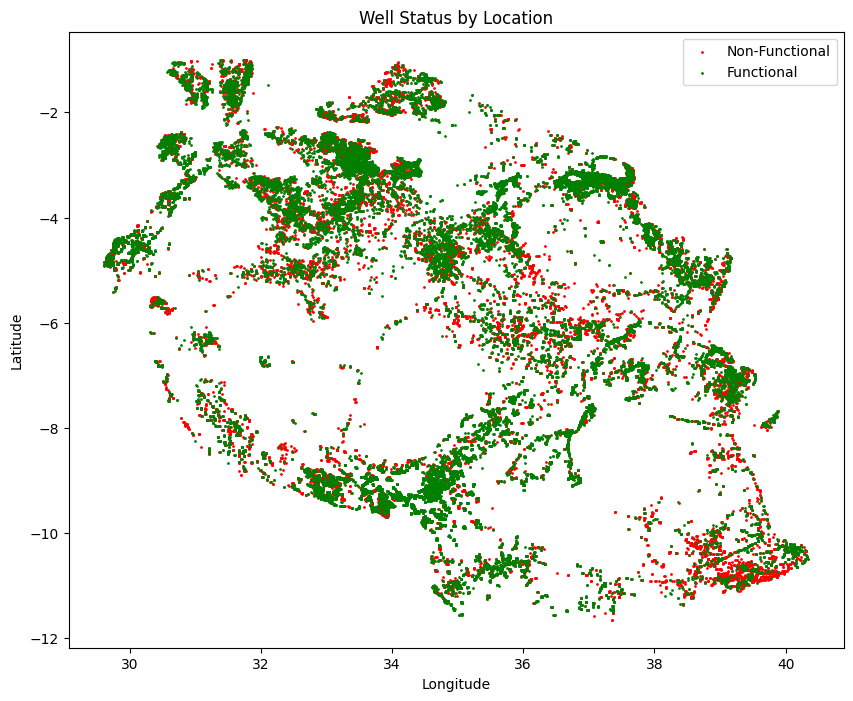

In [8]:
'''
First remove any outliers i.e. 
Cordinates that lie on latitude and longitude 0 as Tanzania doe not lie along the Equator or Meridian Lines'''

longitude_data = train_data[(train_data['latitude'] != 0) & (train_data['longitude'] != 0)]

# Separate functional and non-functional wells
functional_wells = longitude_data[longitude_data['status_group'] == 1]
non_functional_wells = longitude_data[longitude_data['status_group'] == 0]

# Set a marker size
marker_size = 1

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(non_functional_wells['longitude'], non_functional_wells['latitude'], color='red', label='Non-Functional', s=marker_size)
plt.scatter(functional_wells['longitude'], functional_wells['latitude'], color='green', label='Functional', s=marker_size)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Well Status by Location')

# Add a legend
plt.legend()

# Show the plot
plt.show()

As you can see. The data is evenly split across the map. There seems to be no noticable correlation between the location and status of the well.

##### Histograms:
Next we plot a histogram for all numeric features in the dataset to have a look at the distribution of the data



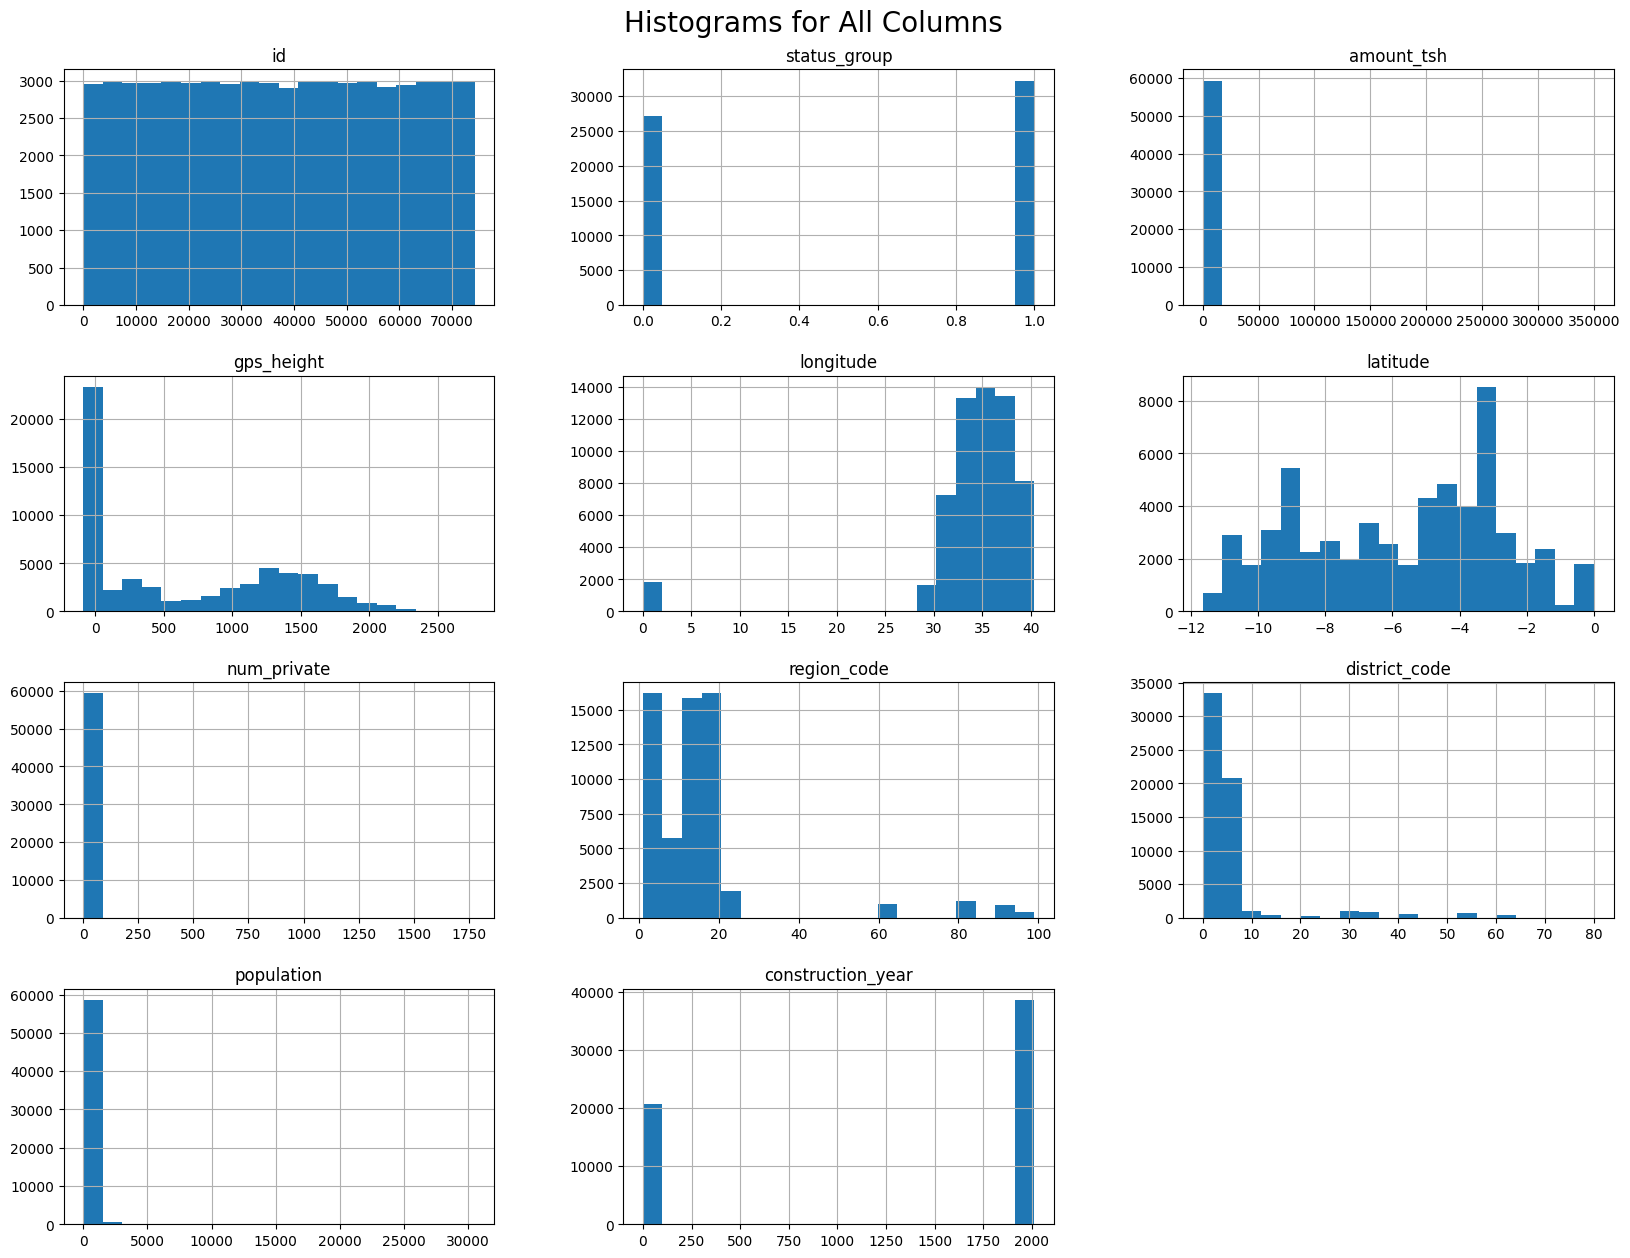

In [9]:
# Histograms for all columns
train_data.hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms for All Columns', x=0.5, y=0.92, fontsize=20)
plt.show()


Other that noticing afew categorical data and outliers in the data. There seems to be nothing much in the distributions.

##### Count Plot:
Count plot to visualize the distribution of data.

In [10]:
# Create a Function to draw count plots
def drawCountPlot(data,column,title, hue):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, hue=hue, data=data)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


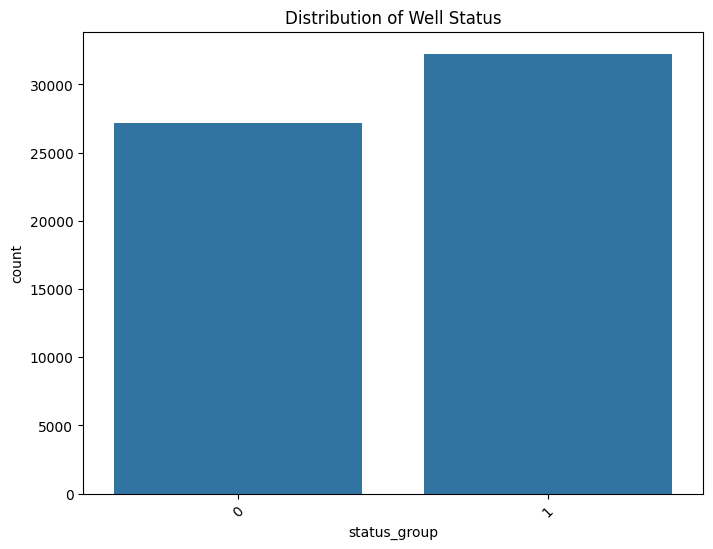

In [11]:
#Drawing a count plot of the target variable
drawCountPlot(train_data,'status_group', 'Distribution of Well Status', None)

A count plot of functional and non functional wells based on the geographic water body can probably give more insights if certain water bodies are more prone to Non Functional wells over time. 

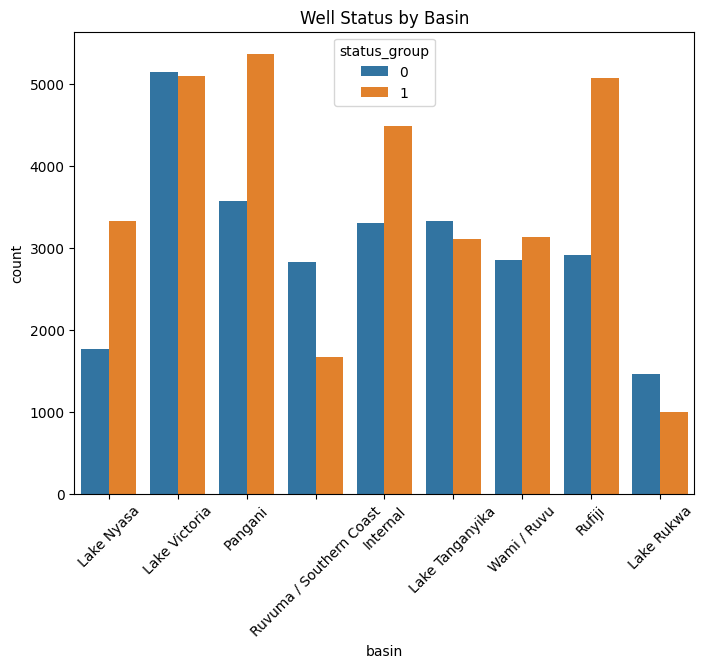

In [12]:
#Drawing a count plot of the wells in a basin grouped by the well status.
drawCountPlot(train_data,'basin', 'Well Status by Basin', 'status_group')

Lake Rufuji has the highest ratio of functional wells as compared to other lakes. While an unknown lake has the highest ratio of non functional wells. The unknown lake might need to be examined further.

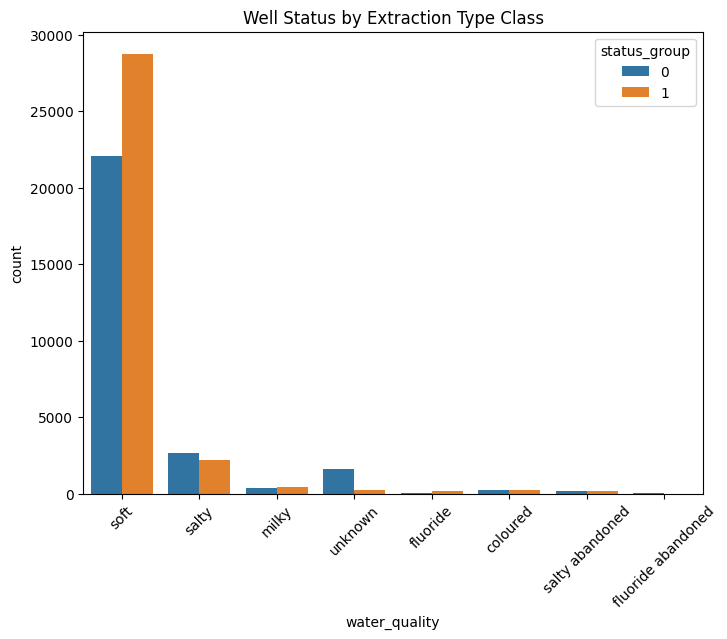

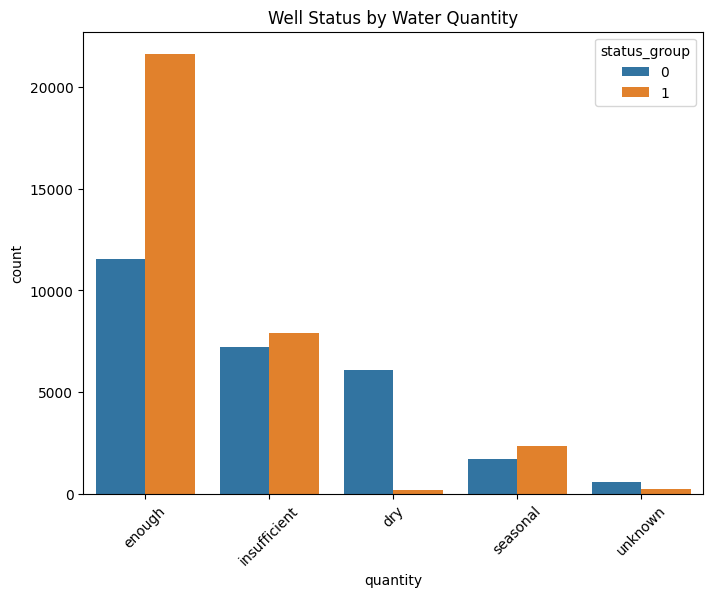

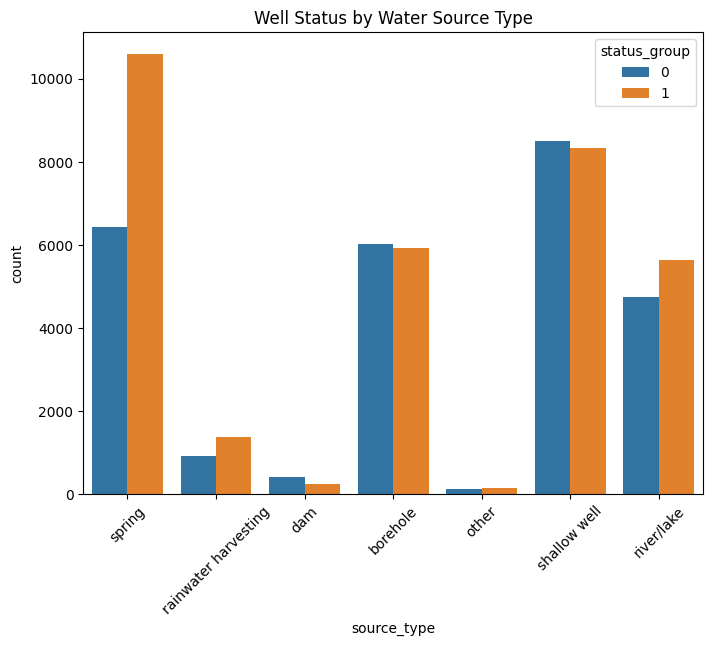

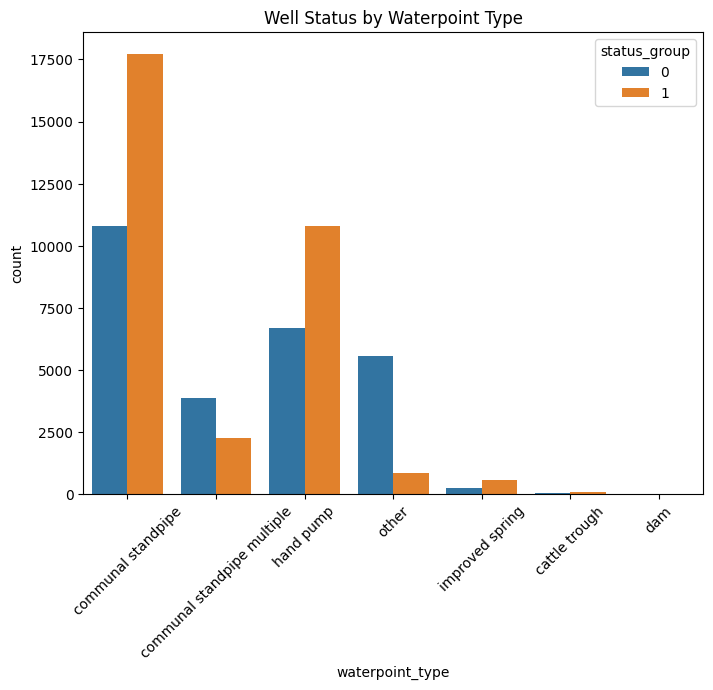

In [13]:
#Ploting different count plots to see the distribution of functional and non functional wells across different features
drawCountPlot(train_data,'water_quality', 'Well Status by Extraction Type Class', 'status_group')

drawCountPlot(train_data,'quantity', 'Well Status by Water Quantity', 'status_group')

drawCountPlot(train_data,'source_type', 'Well Status by Water Source Type', 'status_group')

drawCountPlot(train_data,'waterpoint_type', 'Well Status by Waterpoint Type', 'status_group')

### Feature Engineering:
Additional columns, such as the year of recording, are created to capture relevant information.

In [14]:
# Create a column to store the year recorded from date recorded
train_data['year_recorded'] = train_data['date_recorded'].str[:4].astype(int)

train_data['year_recorded'].head()

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year_recorded, dtype: int32

### Data Preprocessing:
Data preprocessing includes handling missing values and encoding categorical features.

In [15]:
# Loop through all the data to try and identify relevant columns
for column in test_data.columns:
    print(f"\nColumn: {column}")
    print(test_data[column].value_counts())


Column: id
id
50785    1
26155    1
29495    1
67260    1
726      1
        ..
39006    1
38238    1
34634    1
57416    1
68707    1
Name: count, Length: 14850, dtype: int64

Column: amount_tsh
amount_tsh
0.0         10410
500.0         772
50.0          631
1000.0        370
20.0          349
            ...  
14000.0         1
0.2             1
70000.0         1
100000.0        1
2800.0          1
Name: count, Length: 68, dtype: int64

Column: date_recorded
date_recorded
2013-02-03    138
2011-03-16    137
2011-03-17    137
2011-03-18    130
2011-03-14    129
             ... 
2011-09-24      1
2004-01-04      1
2013-01-06      1
2011-09-02      1
2004-01-09      1
Name: count, Length: 331, dtype: int64

Column: funder
funder
Government Of Tanzania    2215
Danida                     793
Hesawa                     580
World Bank                 352
Kkkt                       336
                          ... 
Craelius                     1
Tanroad                      1
Ndanda Miss

This step enabled us to pick columns that had useful data and also columns that can be easily changed to numeric data for easier processing without altering the original data so much

In [16]:
# Drop irrelevant columns
train_data = train_data.drop(columns=["id","date_recorded","funder","installer","wpt_name","subvillage","region","district_code","lga","ward","recorded_by","scheme_management","scheme_name","extraction_type","extraction_type_group","management","payment","water_quality","quantity","source","source_type","waterpoint_type"], axis=1)

In [17]:
# Drop NaN values
train_data = train_data.dropna()

In [18]:
# Get a summary of the data
data_summary(train_data)

----------------Dataset Info-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 53281 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           53281 non-null  int64  
 1   amount_tsh             53281 non-null  float64
 2   gps_height             53281 non-null  int64  
 3   longitude              53281 non-null  float64
 4   latitude               53281 non-null  float64
 5   num_private            53281 non-null  int64  
 6   basin                  53281 non-null  object 
 7   region_code            53281 non-null  int64  
 8   population             53281 non-null  int64  
 9   public_meeting         53281 non-null  object 
 10  permit                 53281 non-null  object 
 11  construction_year      53281 non-null  int64  
 12  extraction_type_class  53281 non-null  object 
 13  management_group       53281 non-null  object 
 14  payment_type 

### Label Encoding:
Label encoding is applied to categorical features.

In [19]:
# Assuming data is your DataFrame
columns_to_encode = ["basin","public_meeting","permit","extraction_type_class","management_group","payment_type","quality_group","quantity_group","source_class","waterpoint_type_group"]  

label_encoder = LabelEncoder()

for column in columns_to_encode:
       train_data[column + '_encoded'] = label_encoder.fit_transform(train_data[column])

# Drop the original columns if needed
train_data = train_data.drop(columns=columns_to_encode)

### One-Hot Encoding:
One-hot encoding is applied to encoded categorical columns.

In [20]:
columns_to_one_hot  = ["basin_encoded","public_meeting_encoded","permit_encoded","extraction_type_class_encoded","management_group_encoded","payment_type_encoded","quality_group_encoded","quantity_group_encoded","source_class_encoded","waterpoint_type_group_encoded"]  
train_data = pd.get_dummies(train_data, columns=columns_to_one_hot , prefix=columns_to_one_hot)

### Model Training:
For my base model. I chose a Logistic Regression model. Before fiting the model. I will use a Standard Scaler to apply a standard scale to the data.

In [21]:
# Split the data into features and target
X = train_data.drop("status_group", axis=1)
y = train_data['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

model

LogisticRegression()

To build upon the base model. I will employ a Random Forest Classifier. The hope is that it would be able to learn better than the Logistic Regression model.

In [22]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation:
The models are evaluated using accuracy and classification reports. Here we will get to see which model performed best.

In [23]:
# Logistic Regression Evaluation
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print("\nLogistic Regression Classification Report:\n", classification_report_result)

# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print("\Random Forest Classification Report:\n", classification_report_rf)


Logistic Regression Accuracy: 0.7350098526789903

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.59      0.67      4797
           1       0.72      0.86      0.78      5860

    accuracy                           0.74     10657
   macro avg       0.74      0.72      0.72     10657
weighted avg       0.74      0.74      0.73     10657



Random Forest Accuracy: 0.8150511400957118
\Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      4797
           1       0.82      0.85      0.83      5860

    accuracy                           0.82     10657
   macro avg       0.81      0.81      0.81     10657
weighted avg       0.81      0.82      0.81     10657



As expected the random forest looks to perform better thatn the Logistic Regression. With an accuracy of 74 compared to 82.

### Hyperparameters tuning.
To evaluate if there are better hyperparameters that can be used. I will use GridSearchCV to run through a couple of parameters and evaluate all of them and finaly return the best hyperparameters the model can use. 

Here I will convert the process into a Pipeline.

In [24]:
class DataLoader(BaseEstimator, TransformerMixin):
    def __init__(self, target_path, train_path):
        self.target_path = target_path
        self.train_path = train_path

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df1 = pd.read_csv(self.target_path)
        df2 = pd.read_csv(self.train_path)
        train_data = pd.merge(df1, df2, on='id')

        train_data['status_group'] = train_data['status_group'].replace({'functional': 1, 'non functional': 0, 'functional needs repair': 0})
        train_data['year_recorded'] = train_data['date_recorded'].str[:4].astype(int)
        train_data = train_data.drop(columns=["id","date_recorded","funder","installer","wpt_name","subvillage","region","district_code","lga","ward","recorded_by","scheme_management","scheme_name","extraction_type","extraction_type_group","management","payment","water_quality","quantity","source","source_type","waterpoint_type"], axis=1)
        train_data = train_data.dropna()

        columns_to_encode = ["basin","public_meeting","permit","extraction_type_class","management_group","payment_type","quality_group","quantity_group","source_class","waterpoint_type_group"]  
        label_encoder = LabelEncoder()

        for column in columns_to_encode:
            train_data[column + '_encoded'] = label_encoder.fit_transform(train_data[column])

        train_data = train_data.drop(columns=columns_to_encode)

        columns_to_one_hot  = ["basin_encoded","public_meeting_encoded","permit_encoded","extraction_type_class_encoded","management_group_encoded","payment_type_encoded","quality_group_encoded","quantity_group_encoded","source_class_encoded","waterpoint_type_group_encoded"]  
        train_data = pd.get_dummies(train_data, columns=columns_to_one_hot , prefix=columns_to_one_hot)

        X = train_data.drop("status_group", axis=1)
        y = train_data['status_group']

        return X, y


class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)


class ModelEvaluator:
    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_report_result = classification_report(y_test, y_pred)
        print(f"Model Accuracy: {accuracy}")
        print("\nModel Classification Report:\n", classification_report_result)


target_path = './data/target.csv'
train_path = './data/train.csv'
test_path = './data/test.csv'

# Load Data
data_loader = DataLoader(target_path=target_path, train_path=train_path)
X, y = data_loader.fit_transform(None)

# Split the data into features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pipeline
pipeline = Pipeline([
    ('scaler', FeatureScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Define the hyperparameters and their possible values for the grid search
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object with the Pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Evaluate the model with the best hyperparameters
evaluator = ModelEvaluator()
evaluator.evaluate_model(grid_search, X_test, y_test)




Best Hyperparameters:
{'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 150}
Model Accuracy: 0.8203059022238904

Model Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      4797
           1       0.81      0.88      0.84      5860

    accuracy                           0.82     10657
   macro avg       0.82      0.81      0.82     10657
weighted avg       0.82      0.82      0.82     10657



### Feature importance.
We can finally see the features that are highly important in the dataset. This can help in future data collection as well as model creation.

In [26]:
# Access feature importances from the best model (RandomForestClassifier in the pipeline)
feature_importances = grid_search.best_estimator_.named_steps['model'].feature_importances_

# Print or visualize feature importances
print("Feature Importances:")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")


Feature Importances:
amount_tsh: 0.035711901762339765
gps_height: 0.06807998442268327
longitude: 0.11694339110371345
latitude: 0.11269062794527365
num_private: 0.0021953182088446975
region_code: 0.034650263326747
population: 0.04447846239556126
construction_year: 0.06736192148365835
year_recorded: 0.013933126119098202
basin_encoded_0: 0.006506924773541788
basin_encoded_1: 0.008050785339638863
basin_encoded_2: 0.004438314608366412
basin_encoded_3: 0.005675097752999302
basin_encoded_4: 0.003942067941143094
basin_encoded_5: 0.004595653580497746
basin_encoded_6: 0.0047478657819267755
basin_encoded_7: 0.004204167494842034
basin_encoded_8: 0.004376101749411011
public_meeting_encoded_0: 0.006384417498135767
public_meeting_encoded_1: 0.006676972685260451
permit_encoded_0: 0.009137172889400861
permit_encoded_1: 0.009144590561022481
extraction_type_class_encoded_0: 0.013565188378618143
extraction_type_class_encoded_1: 0.01397835517056708
extraction_type_class_encoded_2: 0.004700975360076452
extr